<a href="https://colab.research.google.com/github/CatarinaRRF/siRNASeeker_algorithm/blob/main/code/siRNA_Seeker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://raw.githubusercontent.com/CatarinaRRF/siRNA_Seeker/main/static/img/siRNAseeker_preto.png" >
<hr color ='66A80F' size="10">

###### <font color=1D2633><b>Automatizando o design de siRNA</B>

## <font color=0A0908><b> 01. Introdução</b>

Bem-vindo ao siRNA Seeker! Aqui você encontrará uma ferramenta projetada para facilitar a pesquisa e o desenvolvimento no campo da genética e biotecnologia, especificamente na busca por siRNA.

### <font color=66A80F> <b> O que o siRNA Seeker é?</b></font>

O algoritmo apresentado aqui foi desenvolvido para automatizar o processo de design de siRNA. OS siRNA, ou RNA de interferência pequeno, desempenha um papel crucial na regulação da expressão gênica por meio do silenciamento pós-transcricional de genes. Essa capacidade de manipular processos genéticos utilizando siRNA tem sido fundamental para o avanço de novas tecnologias e aplicações na pesquisa científica.

### <font color=66A80F><b>Como Utilizar este Notebook</b> </font>
O Google Colab utiliza células para organizar o código e as explicações. Existem dois tipos principais de células:

* <b>Células de Código:</b> Contêm comandos de programação que executam o algoritmo.
* <b>Células de Texto:</b> Servem para fornecer explicações e instruções sobre o que está acontecendo.
</br>
Para garantir que o algoritmo funcione corretamente, todas as células de código devem ser executadas na ordem em que aparecem. Isso porque algumas células dependem de comandos que foram executados anteriormente.

### <font color=66A80F><b> O que você precisa fazer? </b> </font>

> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

</br>
<hr>
⚠️ <b>Atenção!</b> Para evitar erros, <font color=red><b>execute todas as células na ordem em que aparecem no notebook</font></b>. Isso garante que todas as etapas sejam concluídas corretamente e que o algoritmo funcione sem problemas.

## <font color=0A0908><b> 02. Entrada de dados</b>

<font size=4><b>📤 Como Fazer Upload de um Arquivo no Google Colab</b></font>

Para que o algoritmo funcione corretamente, você precisará **fazer o upload de um arquivo no formato FASTA**.  

✅ **Requisitos do arquivo:**  
- O arquivo **deve estar no formato `.fasta`**.  
- O nome do arquivo **deve ser exatamente** `sequence.fasta`.  

📌 **Passos para fazer o upload:**  

1. **Localize o botão de upload** no notebook, localizado na aba direita do site. O icone é o seguinte:

<center>
    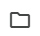
</center>

2. Clique no botão **“Escolher arquivo”**.  
3. Selecione ou arraste seu arquivo `sequence.fasta` do seu computador.  
4. Aguarde o carregamento ser concluído.  
5. **Não pule essa etapa!** O algoritmo precisa desse arquivo para funcionar corretamente.  

⚠️ **Importante:**  
Se o nome do arquivo for diferente de `sequence.fasta`, o código pode não reconhecer os dados e gerar erros. Certifique-se de que o nome está correto antes de fazer o upload.

##### <font color=66A80F><b> Preparando ambiente
<hr color ='66A80F' size="3">

Instalando bibliotecas necessárias  para o funcionamento do algoritimo.

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.


In [ ]:
pip install requests

In [ ]:
pip install biopython==1.85

In [ ]:
pip install seqfold

In [ ]:
pip install ViennaRNA

In [ ]:
# @markdown **Rode esta célula para preparar o ambiente**
# Tratamento dos dados
import Bio
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq

# Mais
import requests
import time
import xml.etree.ElementTree as ET
import json

# Filtros
import re
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import gc_fraction
from seqfold import dg, fold, Struct
import pandas as pd
from ViennaRNA import RNA

# Blast
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIWWW

# Barra de progresso
from tqdm import tqdm
import time

# Mensagem de Sucesso
print('as bibliotecas foram importadas com sucesso')

as bibliotecas foram importadas com sucesso


##### <font color=66A80F><b> Entrada de dados
<hr color ='66A80F' size="3">

<font size=2> Funções que determinam como o algoritimo ira ler o arquivo fasta e extrair a sequencia (`entrada_dados`) e identificando de qual gene se trata (`extract_gene_symbol_from_header`)

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [ ]:
def entrada_dados(tipo='fasta'):
  if tipo == 'fasta':
    # selecionar o arquivo FASTA
    nome_arquivo = "/content/sequence.fasta"

    try:
        # Le o arquivo FASTA e armazena as sequencias em uma lista
        sequencias = list(SeqIO.parse(nome_arquivo, 'fasta'))

        # Verifica se o arquivo nao está vazio
        if len(sequencias) > 0:
          # Define o nome do arquivo de saída
          nome_arquivo_saida = 'meugene.fasta'

          # Salva as sequencias no arquivo de saida
          SeqIO.write(sequencias, nome_arquivo_saida, 'fasta')
          print(f'O arquivo {nome_arquivo} foi salvo como {nome_arquivo_saida}.')

        else:
          print('O arquivo FASTA está vazio.')
    except Exception as e:
          print(f'Ocorreu um erro ao ler o arquivo FASTA: {str(e)}')
  else: print('pedir valdeir')

  return sequencias

In [ ]:
def extract_gene_symbol_from_header(header):
    # Expressão regular para capturar siglas de genes entre parênteses.
    match = re.search(r'\(([^)]+)\)', header)
    if match:
        return match.group(1)
    return None

def meta_data(sequence, tamanho, autor, form_id):
  sequencias = list(SeqIO.parse(sequence, 'fasta'))
  # Gene Symbol
  header = sequencias[0].description
  gene_symbol = extract_gene_symbol_from_header(header)
  # RefSeq acenssion number
  refseq_numbers = sequencias[0].name
  # Original gene Size
  gene_size = len(sequencias[0].seq)
  # dic
  meta = {
          'Form_id': form_id, #enter data
          'gene_symbols': gene_symbol, #run funciton
          'refseq_numbers': refseq_numbers, #run function
          'autor':autor, #enter data
          'gene_size': gene_size, #run function
          'sirna_size':tamanho, #enter data
  }
  return meta

> <font size=2 color=66A80F><b> executando a função

In [ ]:
sequencias = entrada_dados()
sequencias

O arquivo /content/sequence.fasta foi salvo como meugene.fasta.


[SeqRecord(seq=Seq('CTTTTTGGTGTAAATCTGGACTCTAATTCTGTAATATATCAAGGAATCTCGTAA...AAA'), id='NM_004502.4', name='NM_004502.4', description='NM_004502.4 Homo sapiens homeobox B7 (HOXB7), mRNA', dbxrefs=[])]

## <font color=0A0908><b> 03. Construção dos possiveis siRNA</b>

Em seguida devemos trasformar a sequencia em RNA (`trascrever`) realizada pela função [Bio.Seq.transcribe](https://biopython.org/docs/1.75/api/Bio.Seq.html#Bio.Seq.transcribe) da biblioteca Biopython. Essa função converte a sequência de DNA em RNA, substituindo as bases de timina (T) por uracila (U). Essa transformação é essencial para que possamos analisar corretamente as sequências pois, certos critérios de avaliação analisam a uracila.

Após a transcrição, o código procede com a identificação de todas as possíveis sequências de siRNA (`possiveis_siRNA`). O algoritmo então itera sobre a sequência de RNA transcrita, gerando substrings do comprimento especificado, para encontrar todas as possíveis sequências de siRNA que serão analisadas conforme os critérios estabelecidos.

Por exemplo, considere a seguinte sequência de RNA transcrita:
<font color=66A80F>
  <b>
    <center>
      <code>
      123456789</br>AUGGAGUUC
      </code>
    </center>
  </b>
</font>

E queremos gerar subsequências de tamanho 3 (simulando um siRNA de 3 nucleotídeos para simplificação).

A iteração sobre essa sequência de RNA produziria:
><font color=66A80F>
  <b>
  <font color=black> Sequência 1:</font></br>
    <center>
      <code>
      123</br>AUG
      </code>
    </center>
  <font color=black> Sequência 2:</font></br>
    <center>
      <code>
      234</br>UGG
      </code>
    </center>
  </b>
  <font color=black> ... </font></br></br>
  <font color=black><b> Sequência 7: </b></font></br>
    <center>
      <code>
      789</br>UCU
      </code>
    </center>
</font>

<hr>

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.


##### <font color=66A80F><b> Trascrevendo em RNA
<hr color ='66A80F' size="3">

<font size=2>Para realizar a análise da sequência de DNA fornecida, utilizaremos a função <font color=66A80F>`transcrever()`</font>, onde, convertera a sequência de DNA em uma sequência de RNA.  
> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [ ]:
def transcrever(sequencias):
    for sequencia in sequencias:
        name = sequencia.name

     # Converte as letras T para U
        sequencia_convertida = Bio.Seq.transcribe(sequencia.seq)
        return sequencia_convertida, name


##### <font color=66A80F><b>Achando todas as possiveis sequencias de siRNA
<hr color ='66A80F' size="3">

<font size=2> Usando a função <b><font color=66A80F>`possiveis_siRNA()`</font></b> o algotimo busca na sequência de RNA por potenciais siRNA de tamanho especifico e as salva em uma lista separada.
> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [ ]:
def possiveis_siRNA(dado, tamanho=21):
    # definindo variaveis
    possiveis_siRNA = []
    tuplas = []
    # iterando
    for index, _ in enumerate(dado):
        f = index + tamanho
        sequence_p = Seq(dado[index:f])  # convertendo para objeto Seq
        possiveis_siRNA.append(str(sequence_p))
        tuplas.append((str(sequence_p), f'{index}:{index+tamanho}'))

    siRNA = possiveis_siRNA[:-tamanho]

    return siRNA, tuplas

##### <font color=66A80F><b> Executando a Função </b>


> <font size=2>Adicione o tamanho da sequência do siRNA, sendo o padrão recomendado de 21 nucleotídeos. Não insira valores menores que 10, pois isso resultará em erro.

In [ ]:
Tamanho = 21 # @param {type:"integer"} { run: "auto" }
Tamanho_1 = Tamanho-1

a = transcrever(sequencias)
name = a[1]
sequencia_convertida = a[0]
candidates, tuplas = possiveis_siRNA(sequencia_convertida, tamanho=Tamanho)
print(f'\n * N° de Candidatos:\n {len(candidates)}')


 * N° de Candidatos:
 1342


## <font color=0A0908><b> 04. Classificação dos siRNA quando sua funcionalidade</b>

Após a seleção das sequências possíveis, o algoritmo inicia sua análise aplicando os critérios de otimização estabelecidos por três autores: **Reynolds et al. (2004), Ui-Tei et al. (2004) e Amarzguioui et al.** O usuário pode optar pelo autor cujas diretrizes prefere seguir na determinação da funcionalidade das sequências. Embora existam diferenças entre os critérios utilizados por cada autor, alguns parâmetros são avaliados de forma geral, como **energia livre, conteúdo de GC e temperatura de melting**.

Cada critério recebe uma pontuação conforme sua importância dentro do modelo proposto pelo autor correspondente. Essa pontuação é representada pelo **"score"**, um parâmetro criado especificamente para este algoritmo que determina a conformidade da sequência analisada. A forma como a pontuação é calculada varia entre os autores, conforme demonstrado nas tabelas abaixo:

</br>

---

**Score para Reynolds et al. (2004)**  

| Critério | Score |
|----------|---------|
| Estabilidade interna (posição 15-19) – pelo menos um A ou G | +2 |
| Base na posição 13 ≠ G | +1 |
| Base na posição 19 ≠ G ou C | +1 |
| Base na posição 19 = A | +1 |
| Base na posição 10 = U | +1 |
| Base na posição 3 = A | +1 |
| Energia livre entre -7.2 e -3.6 kcal/mol | **+2** |
| **Pontuação máxima** | **9** |

<font size=2><b>No caso de temperature de melting maior que 21.5°C a sequência é eliminada</b></font>

</br>

---

**Score para Ui-Tei et al. (2004)**  

| Critério | Score |
|----------|---------|
| Exatamente 5 C/G nas primeiras 7 bases do sentido | +1 |
| Todas as 7 últimas bases do antisenso serem A/U | +1 |
| Pelo menos 5 A/U nas 7 últimas bases do antisenso | +2 |
| Nenhuma sequência de 9 C/G consecutivos | +1 |
| Presença de uma sequência de 9 C/G consecutivos | -2 |
| Temperatura de melting < 21°C | **+1** |
| **Pontuação máxima** | **6** |
| **Pontuação mínima** | **-2** |

<font size=2><b>No caso de energia livre fora do intervalo -13 a -7 a sequência é eliminada</b></font>

</br>

---

**Score para Amarzguioui et al.**  

| Critério | Score |
|----------|---------|
| Base na posição 1 ≠ U | +1 |
| Base na posição 1 = C ou G | +1 |
| Base na posição 6 = A | +1 |
| Base na posição 19 ≠ G | +1 |
| Base na posição 19 = A ou U | +1 |
| Assimetria – mais A/U na extremidade 3' do que na 5' | +1 |
| Energia livre entre -7.2 e -3.6 kcal/mol | **+2** |
| Temperatura de melting < 21°C | **+1** |
| **Pontuação máxima** | **9** |

</br>

---

Os siRNAs candidatos são avaliados de acordo com esses critérios para determinar sua viabilidade. A pontuação final será transformada em percentual e, para garantir que apenas as sequências mais promissoras avancem, somente aquelas que apresentarem uma **conformidade superior a 60%** (pontuação proporcionalmente ajustada) seguirão para as próximas fases do processo.


##### <font color=66A80F><b>  Reynolds
<hr color ='66A80F' size="3">

Reynolds et al. (2004) realizaram uma análise detalhada de 180 siRNAs e os seguintes critérios específicos para otimizar a eficiência desses siRNAs foram determinados:

**Características da sequência (Fita Senso)**

| Posição | Nucleotídeo Recomendado |
| ------- | ----------------------- |
| 3       | A                       |
| 10      | U                       |
| 13      | Exceto G                 |
| 19      | Exceto G e C             |
| 19      | A                       |

**Características que influenciam a termodinâmica**

| Critério                                  | Descrição                                                    |
| ----------------------------------------- | ------------------------------------------------------------ |
| Ausência de repetições invertidas (hairpin) | Sequências com alta Tm favorecem estruturas secundárias (hairpin). Tm < 20ºC |
| Estabilidade interna baixa (3+ A/U)       | A extremidade 3' da fita senso (posições 15-19) deve ter A/U para aumentar a eficácia do siRNA |
| Baixo conteúdo de GC                      | Conteúdo de GC entre 30% e 52%; |

In [ ]:
def reynolds (sequence):
  score = 0
  falha = []
  # Instabilidade na position 15 - 19
  #----------------------------------#
  check_estabilidade = 0
  for letra in sequence[14:19]:
     if letra == "A" or letra == "G":
        check_estabilidade += 1
  if check_estabilidade >= 1:
     score += 2
  else:
     falha.append(str("internal stability"))

  # Caracteristicas da Fita
  # position 13
  #----------------------------------#
  if sequence[12] != "G":
     score += 1
  else:
     falha.append(str("position 13"))
  # position 19
  #----------------------------------#
  if sequence [18] != "G" and sequence [18] != "C":
     score += 1
  else:
     falha.append(str("position 19"))
  if sequence [18] == "A":
     score += 1
  else:
     falha.append(str("position 19!= A"))
  # position 10
  #----------------------------------#
  if sequence [9] == "U":
     score += 1
  else:
     falha.append(str("position 10"))

  # position 3
  #----------------------------------#
  if sequence [2] == "A":
     score += 1
  else:
     falha.append(str("position 3"))

  return score, falha

##### <font color=66A80F><b>  Ui-Tei
<hr color ='66A80F' size="3">



Ui-Tei et al. (2004) realizaram uma análise de siRNA em diferentes tipos celulares e estabeleceram critérios específicos para otimizar a eficácia desses siRNA. Eles focaram principalmente em características da sequência e estabilidade termodinâmica.

**Características da sequência**

| Posição | Nucleotídeo Recomendado | Descrição |
| ------- | ----------------------- | --------- |
| 5' Extremidade da fita antisenso | A/U | A extremidade 5' da fita antisenso deve conter nucleotídeos A/U, </br> relacionada à formação do RISC e ao reconhecimento do RNAm. |
| 5' Extremidade da fita senso | G/C | A extremidade 5' da fita senso deve conter nucleotídeos G/C. |
| 5' Extremidade da fita antisenso | Pelo menos 5 A/U | A extremidade 5' da fita antisenso deve ter pelo menos cinco </br> nucleotídeos A/U consecutivos de um total de sete. |
| Sequência G/C consecutiva | Nenhuma sequência de mais de 9 G/C consecutivos | A sequência não deve ter mais de nove nucleotídeos G/C seguidos. |

**Considerações de estabilidade e eficiência**

| Critério                               | Descrição                                                                                                                                                  |
| -------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Estabilidade interna baixa (ΔGº)      | SiRNA mais eficazes apresentaram ΔGº entre -3,6 a -7,2 kcal/mol. </br> siRNA ineficazes tiveram ΔGº maior que -9,8 kcal/mol.                                 |
| Relação com eficiência                 | A estabilidade interna baixa está correlacionada com a maior eficiência funcional do siRNA. </br>SiRNA com ΔGº mais baixo demonstraram maior eficiência no silenciamento. |

</br>

In [ ]:
sequence = 'CUUGGCGGCCGAGAGUAACUU'

sequence[:7]

'CUUGGCG'

In [ ]:
def Ui_Tei (sequence, extremidade=7):
  # Variaveis
  #----------------------------------#
  score = 0
  falha = []
  antisenso = Seq(sequence).complement_rna()

  #Senso
  #----------------------------------#
  check_senso = 0

  for letra in sequence[:extremidade]:
      if letra == "G" or letra == "C":
         check_senso += 1
  if check_senso > 0:
     score += 1
  else:
     falha.append(str("no C/G at the 5' sense end"))

  #Antisenso
  #----------------------------------#
  check_antisenso = 0

  for letra in antisenso[:extremidade]:
      if letra == "A" or letra == "U":
         check_antisenso += 1
  if check_antisenso > 0:
     score += 1
  else:
     falha.append(str("no A/U at the 5' antisense end"))

  # Presença de no minimo 5 A/U nas posições [:7]
  #----------------------------------#
  check_min_5 = 0

  for letra in antisenso[-extremidade:]:
      if letra == "A" or letra == "U":
         check_min_5 += 1
  if check_min_5 >= 5:
     score += 2
  else:
     falha.append(str("Less than 5 A/U in antisense 5"))

  # Mais de 9 repetições
  #----------------------------------#
  segment_size = 9
  check = True

  for index in range(len(sequence) - segment_size + 1):
        segmento = sequence[index:index + segment_size]
        count = 0
        for letra in segmento:
            if letra == 'C' or letra == 'G':
                count += 1
        if count >= segment_size:
            check = False

  if check == True:
    score += 1
  else:
    falha.append(str("Repetition of more than 9 C/G in a row"))
    score -= 2

  return score, falha

##### <font color=66A80F><b>  Amarzguioui
<hr color ='66A80F' size="3">

Amarzguioui et al. (2005) realizaram uma análise de 46 moléculas de siRNA, complementares a quatro genes, com o objetivo de avaliar a eficiência de knockdown. Após testes, 21 (46%) dos siRNAs atingiram um critério de eficiência de 70%. A partir desse estudo, os autores propuseram critérios específicos que se mostraram eficazes para o design de siRNAs eficientes.

**Características da sequência**

| Posição | Nucleotídeo Recomendado         | Descrição                                                                                                  |
| ------- | ------------------------------- | -------------------------------------------------------------------------------------------------------- |
| Posição 1 | Não U                           | A posição 1 não deve conter U para evitar redução na eficiência do siRNA.                                 |
| Posição 1 | G ou C                          | A presença de G ou C melhora a formação do duplex, sendo nucleotídeos com ligação forte.                  |
| Posição 6 | A                               | A presença de A é importante para a eficiência do siRNA.                                                  |
| Posição 19 | Não G                           | A presença de G prejudica a formação do duplex, devendo ser evitada.                                      |
| Posição 19 | A ou U                          | A ou U são preferidos nesta posição, pois suas interações mais fracas contribuem para a eficiência.       |

**Assimetria das extremidades do duplex**

| Critério                          | Descrição                                                                                                  |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------- |
| Assimetria das extremidades       | A diferença entre A/U nos três pares de bases terminais em qualquer extremidade do duplex deve ser grande. |

</br>

In [ ]:
def Amarzguioui(sequence):
  score = 0
  falha = []
  check_assimetria_5 = 0
  check_assimetria_3 = 0
  antisenso = Seq(sequence).complement_rna()

  # position 1
  #----------------------------------#
  if sequence [0] != "U":
     score += 1
  else:
     falha.append(str("position 1"))

  if sequence [0] == "C" and sequence [0] == "G":
     score += 1
  else:
     falha.append(str("position 1 has no C/G"))

  # position 6
  #----------------------------------#
  if sequence [5] == "A":
     score += 1
  else:
     falha.append(str("position 6"))
  # position 19
  #----------------------------------#
  if sequence [18] != "G":
     score += 1
  else:
     falha.append(str("position 19 is G"))

  if sequence [18] == "A" or sequence [18] == "U":
     score += 1
  else:
     falha.append(str("position 19 is C/G"))
  # Assimetria
  #----------------------------------#
  for letra in sequence[:3]:
      if letra == "A" or letra == "U": # baixo
         check_assimetria_5 += 1
  for letra in antisenso[-3:]:
      if letra == "A" or letra == "U": # alto
         check_assimetria_3 += 1
  if check_assimetria_3 > check_assimetria_5:
     score += 2
  else:
     falha.append(str("asymmetry"))

  return score, falha

##### <font color=66A80F><b>  Função para a funcionalidade do siRNA
<hr color ='66A80F' size="3">

In [ ]:
def free_energy(seq1):
    seq1_obj = Seq(seq1)
    complementary_seq_str = str(seq1_obj.complement())
    result = RNA.duplexfold(seq1, complementary_seq_str)
    mfe = round(result.energy,3)  # Free energy in kcal/mol

    return mfe

In [ ]:
def siRNA_score (sequence, tuplas,
                 autor=['reynolds', 'ui-tei', 'amarzguioui'],
                 tm=True, tmmax = 21.5):
        """
        Avalia o score e a conformidade do siRNA com base em diversos parâmetros.

        :param sequence: Sequência do siRNA para avaliação.
        :param autor: Lista de autores para o método de scoring.
        :param tm: Flag para calcular a temperatura de fusão (melt temperature).
        :param tmmax: Valor máximo para a temperatura de fusão.
        :param tuplas: Lista de tuplas contendo siRNA e suas posições.
        :return: Score, lista de falhas, conteúdo GC, energia livre e temperatura de fusão.
        """
        # Definindo variaveis
        #--------------------------------------------------------------#
        score = 0
        falha = []
        posicao = 'Não encontrado'

        # Conteudo Baixo GC
        #--------------------------------------------------------------#
        conteudo_gc = round(gc_fraction(sequence)*100, 2)
        if 30 <= conteudo_gc <= 52:
            score += 1

        # tempmelt
        #--------------------------------------------------------------#
        tm_score = round(mt.Tm_GC(sequence[1:9]), 2)
        if autor != 'reynolds':
            if 0 < tm_score <= tmmax:
                score += 1
            else:
                falha.append(str("tm"))

        # G°
        #--------------------------------------------------------------#
        energia_livre = free_energy(sequence[1:9])
        if autor != 'ui-tei':
            if -13 < energia_livre < -7:
                score += 2
            else:
                falha.append(str("free energy"))

        # Autores
        # Score reynolds total = 10
        #--------------------------------------------------------------#
        if autor == 'reynolds':
            r = reynolds(sequence)
            score += r[0]
            falha.extend(r[1] if isinstance(r[1], list) else [r[1]])

        # Score ui-tei total = 7
        #--------------------------------------------------------------#
        if autor == 'ui-tei':
            u = Ui_Tei(sequence)
            score += u[0]
            falha.extend(u[1] if isinstance(u[1], list) else [u[1]])

        # Score amarzguioui total = 4
        #--------------------------------------------------------------#
        if autor == 'amarzguioui':
            a = Amarzguioui(sequence)
            score += a[0]
            falha.extend(a[1] if isinstance(a[1], list) else [a[1]])

        # Encontrando a posição do siRNA nas tuplas
        #--------------------------------------------------------------#
        if tuplas:
            for seq, pos in tuplas:
                if sequence == seq:
                    posicao = pos
                    break
        #--------------------------------------------------------------#
        return score, falha, conteudo_gc, energia_livre, tm_score, posicao

##### <font color=66A80F><b>Selecionando siRNA funcionais
<hr color ='66A80F' size="3"></b>

In [ ]:
def filtro_siRNA(sequences, tuplas, conformidade=0.6,
                    autor=['reynolds', 'ui-tei', 'amarzguioui'],
                    tm=True, tmmax=21.5):
        """
        Filtra e avalia siRNAs com base em parâmetros de conformidade e scoring.

        :param sequences: Lista de sequências de siRNA para avaliação.
        :param conformidade: Nível de conformidade para filtrar siRNAs.
        :param autor: Lista de autores para métodos de scoring.
        :param tm: Flag para calcular a temperatura de fusão (melt temperature).
        :param tmmax: Valor máximo para a temperatura de fusão.
        :param tuplas: Lista de tuplas contendo siRNA e suas posições.
        :return: Dados JSON e lista de siRNAs verificados.
        """
        # Definindo Variaveis
        # --------------------------------------------------------------#
        siRNA_verificados = []
        posicao = []
        score = []
        falha = []
        conteudo_gc = []
        energia_livre = []
        TM_score = []

        total_reynolds = 9 * conformidade
        total_uitei = 6 * conformidade
        total_ama = 10 * conformidade


        # Iterador
        # --------------------------------------------------------------#
        for index, sequence in enumerate(sequences):
            # Veficando a qualidade
            # ----------------------------------#
            resultado = siRNA_score(sequence=sequence, tuplas=tuplas, autor=autor,
                                    tm=tm, tmmax=tmmax)

            # Exclui RNAs indesejadas
            # ----------------------------------#
            incluir_siRNA = True

            if 30 <= resultado[2] <= 52:
                incluir_siRNA = False

            if autor == "reynolds":
                if resultado[0] <= total_reynolds or not (0 < resultado[4] <= tmmax):
                    incluir_siRNA = False

            if autor == 'ui-tei':
              if resultado[0] <= total_uitei or not (-13 < resultado[3] <-7):
                    incluir_siRNA = False

            if autor == 'amarzguioui':
                if resultado[0] <= total_ama:
                    incluir_siRNA = False

            if incluir_siRNA:
                siRNA_verificados.append(sequence)
                score.append(resultado[0])
                falha.append(resultado[1])
                conteudo_gc.append(resultado[2])
                energia_livre.append(resultado[3])
                TM_score.append(resultado[4])
                posicao.append(resultado[5])

        # Organizando os resultados por pontuação
        resultados = list(zip(siRNA_verificados, score, TM_score, conteudo_gc, energia_livre, falha, posicao))
        resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)[:50]
        siRNA_verificados = [resultado[0] for resultado in resultados_ordenados]
        score = [resultado[1] for resultado in resultados_ordenados]
        TM_score = [resultado[2] for resultado in resultados_ordenados]
        conteudo_gc = [resultado[3] for resultado in resultados_ordenados]
        energia_livre = [resultado[4] for resultado in resultados_ordenados]
        falha = [resultado[5] for resultado in resultados_ordenados]
        posicao = [resultado[6] for resultado in resultados_ordenados]

        #"score, falha, conteudo_gc, energia_livre, tm_score, posicao"

        # Preparando dados para JSON
        dados_json = [
            {
                "Sequencia'": resultado[0],
                "Pontuacao": resultado[1],
                "TM": resultado[2],
                "CG": resultado[3],
                "AG": resultado[4],
                "Falhas": resultado[5],
                "posicao":resultado[6],
            }
            for resultado in resultados_ordenados
        ]

        # Salvando em um arquivo JSON
        with open('resultados_siRNA.json', 'w') as arquivo_json:
            json.dump(dados_json, arquivo_json, indent=4)

        return dados_json, siRNA_verificados

##### <font color=66A80F><b>Resultado
<hr color ='66A80F' size="3"></b>

In [ ]:
# @markdown ---
# @markdown ### **Insira os valores para cada parâmetros de funcionalidade**
identidades = 0.6 # @param {type:"number"}
autores = 'reynolds' # @param ["reynolds", "ui-tei", "amarzguioui"]
temperatura_de_melting_maxima = 21.5 # @param {type:"number"}
Tamanho = 21 # @param {type:"integer"} { run: "auto" }

Tamanho_1 = Tamanho-1

a = transcrever(sequencias)
name = a[1]
sequencia_convertida = a[0]
candidates, tuplas = possiveis_siRNA(sequencia_convertida, tamanho=Tamanho)

df, siRNA_verificados = filtro_siRNA(candidates, conformidade= identidades, tuplas=tuplas,
                      autor=autores,
                      tm=True,
                      tmmax = temperatura_de_melting_maxima)

df = pd.json_normalize(df)
print(len(df)," selecionados")
df.head(10)

50  selecionados


,Sequencia',Pontuacao,TM,CG,AG,Falhas,posicao
0,AUAGGGAAGUAAAAAAACAAA,9,5.40,23.81,-7.3,[],842:863
1,CCACUCGCGUGUUCCCCAAGC,9,15.65,66.67,-7.1,[],1240:1261
2,GAGCCGAGUUCCUUCAACAUG,8,10.53,52.38,-9.4,[position 3],339:360
3,GCGCGCCCUUUGAGCAGAACC,8,20.78,66.67,-9.6,[position 3],364:385
4,CGAGGCCGCCAGACCUACACC,8,20.78,71.43,-7.3,[position 10],513:534
5,ACCGGCGCAUGAAGUGGAAAA,8,20.78,52.38,-7.3,[position 3],658:679
6,GAAAGGGAGAGGAAGAGAAGC,8,5.40,52.38,-7.7,[position 10],785:806
7,GGAGCCCCAAAACCUACCACU,8,15.65,57.14,-9.6,[position 10],1224:1245
8,GGACUCUAAUUCUGUAAUAUA,7,0.28,28.57,-2.7,[free energy],17:38
9,GUCCCUGCCUACAAAUCAUCC,7,15.65,52.38,-7.2,"[position 19!= A, position 3]",69:90
